In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import subprocess
import os
import pickle

from spam_cluster import get_response_times

# Set the working directory to the root of the project
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
os.chdir(parent_dir)

print(f'Current working directory: {os.getcwd()}')

divide_at = 3

interval = 1000
rps = 120
random_rps = False
# every = 3
initial_rps = rps

url = f"http://localhost:31923/predict"
USERS = 5
recordings = 30
time_step = 5

# apis = 3
command = ['python', 'code/spam_cluster.py', '--users', str(rps), '--interval', str(interval)]

Current working directory: /home/jprodanov/resource-elastisity-nancy


In [2]:
from utils import init_nodes

# used to count the number of replicas
nodes = init_nodes(debug=True, custom_label='app=localization-api')

Observable pods/nodes:
e6-orancloud:193.2.205.13, ca: 10.1.28.195, pods: []
raspberrypi2:193.2.205.183, ca: 10.1.225.1, pods: [('localization-deployment-c5cd47b8f-hgq5d', 'localization-api', '10.1.225.48')]
raspberrypi1:193.2.205.192, ca: 10.1.245.4, pods: [('localization-deployment-c5cd47b8f-pn7mk', 'localization-api', '10.1.245.9')]



In [3]:
# Set latex rendering
from matplotlib import rc

rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

In [4]:
hpa_rts = []
hpa_container_recordings = [] # Idk?
num_replicas = []
replica_changes = []

In [5]:

spam_process = subprocess.Popen(command)

for i in range(recordings):
    start_time = time.time()
    rts = np.mean([rt for rt in get_response_times(USERS, f'{url}') if rt is not None])
    mean_rt = rts
    hpa_rts.append(mean_rt)

    replicas = 0
    for node in nodes:
        node.update_containers(debug=True, custom_label='app=localization-api')
        replicas += len(node.get_containers().values())
    num_replicas.append(replicas)

    if i > 0 and num_replicas[i] != num_replicas[i - 1]:
        replica_changes.append((i, num_replicas[i]))

    elapsed_time = time.time() - start_time
    time.sleep(max(0, time_step - elapsed_time))

spam_process.terminate()
# infer_process.terminate()

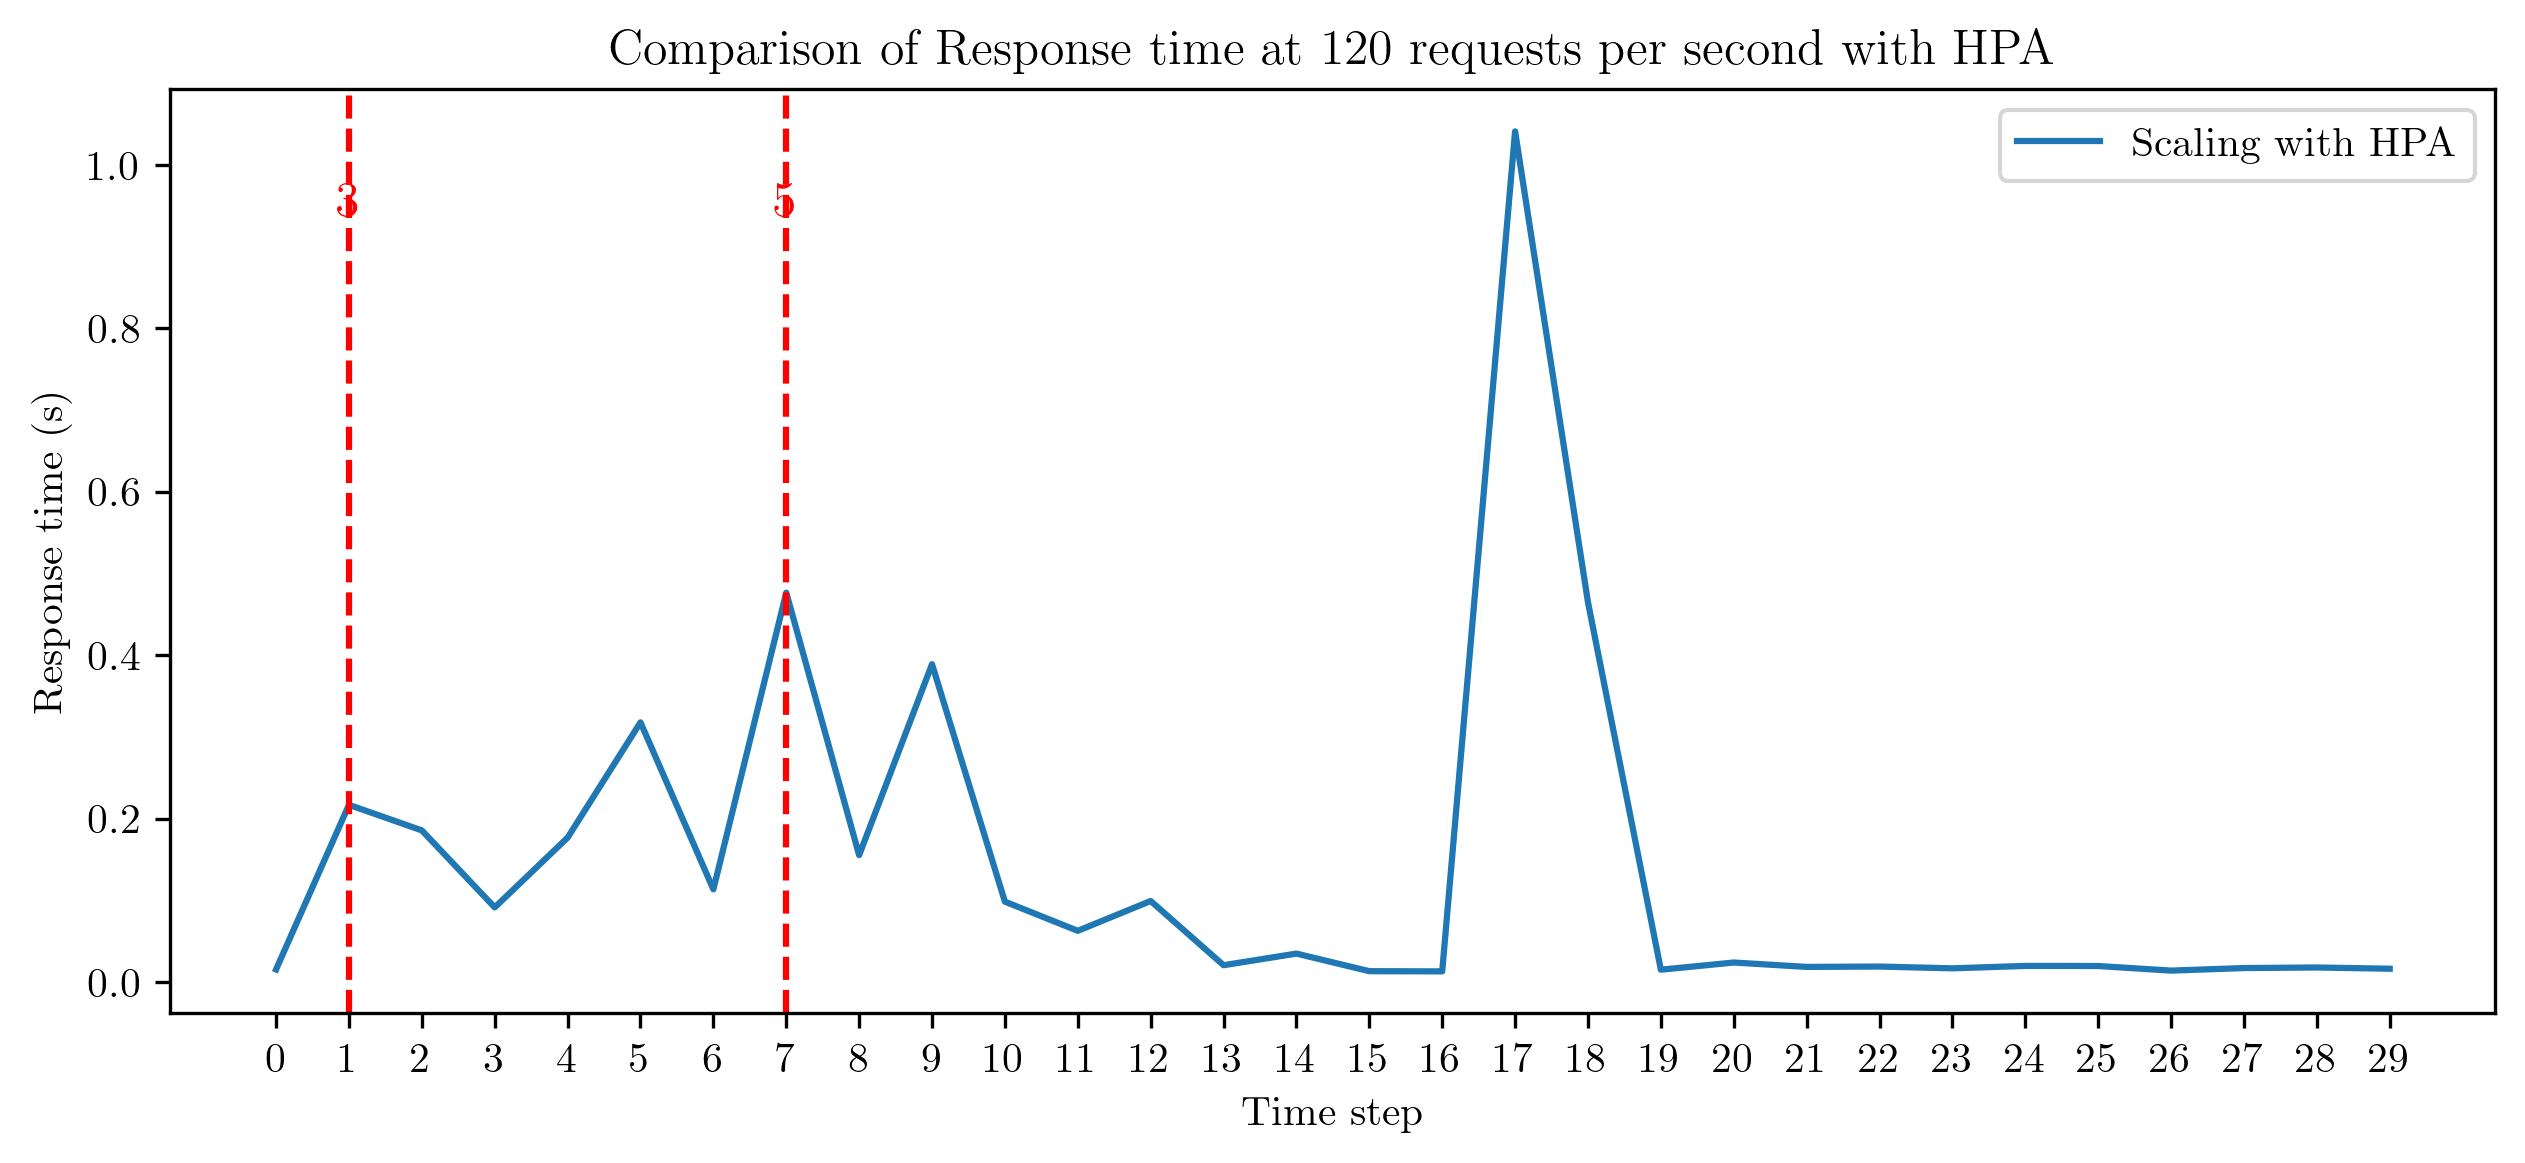

In [6]:
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(hpa_rts, label='Scaling with HPA')

for time_step, num_replicas in replica_changes:
    plt.axvline(x=time_step, color='r', linestyle='--')
    plt.text(time_step, max(hpa_rts) * 0.9, str(num_replicas), color='r', fontsize=12, ha='center')

plt.xlabel('Time step')
plt.ylabel('Response time (s)')
plt.title(f'Comparison of Response time at {initial_rps} requests per second with HPA')
plt.legend()

plt.xticks(range(len(hpa_rts)))

plt.show()

In [7]:
data = {
    'response_times': hpa_rts,
    'divide_at': divide_at,
}
with open('response_times_hpa.pkl', 'wb') as f:
    pickle.dump(data, f)